In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from tqdm import tqdm
import keras
from keras import layers
import os
import random
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import plotly.graph_objects as go
import pandas as pd

seed = 2727
os.environ['PYTHONHASHSEED']=str(seed)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

c:\Users\jigna\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Heat Equation with Dirichlet boundary conditions on $[0,T]\times[0,c]$:

\begin{align}
\partial_t u(t,x) &= \partial^2_{xx}u(t,x) \\
u(0,x) &= x^2(2 - x)\\
u(t,0) &= 0\\
u(t,c) &= 0 
\end{align}

Here time-space is modeled by $(t,x)\in[0,T]\times[0,c]$, thus $u\colon[0,T]\times[0,c]\to \R$


In [3]:
class Network:
    def __init__(self, layers_list: list) -> None:
        self.layers_list = layers_list

    def build(self):
        input_dim = self.layers_list.pop(0)
        ouput_dim = self.layers_list.pop()
        
        array = [layers.Input(shape=(input_dim,))]
        for units in self.layers_list:
            array.append(layers.Dense(units, activation="tanh", kernel_initializer="he_normal", bias_initializer="zeros"))
        array.append(layers.Dense(ouput_dim, kernel_initializer="he_normal", use_bias=False))
        
        nn = keras.Sequential(array)

        return nn


In [3]:
class HeatModel:
    # 1D Heat equation PINN-solver. It contains its own nn.
    def __init__(self):

        self.model = Network([2,32,32,32,32,32,32,1]).build()
    
    def init_condition(self, data):
        n = data.shape[0]
        return tf.reshape(data[...,1]**2 * (2-data[...,1]), shape=(n,1))
    
    ##################### LOSS METHODS ###########################

    def pde_loss(self, data):

        # Error given by the PDE over data.
        
        with tf.GradientTape() as tape2:
            tape2.watch(data)
            with tf.GradientTape() as tape1:
                tape1.watch(data)
                u = self.model(data)
            u_z = tape1.batch_jacobian(u, data)
        u_zz = tape2.batch_jacobian(u_z, data)
        u_t = u_z[...,0,0]
        u_xx = u_zz[...,0,1,1]
        return tf.reduce_mean(tf.math.square(u_t - u_xx))

    def boundary_loss(self, data_init, data_left, data_right):
        l1 = tf.reduce_mean(tf.math.square(self.model(data_left)))
        l2 = tf.reduce_mean(tf.math.square(self.model(data_right)))
        l3 = tf.reduce_mean(tf.math.square(self.model(data_init) - self.init_condition(data_init)))
        return l1 + l2 + l3
    
    def total_loss(self, data_int, data_init, data_left, data_right):
        #self.pde_loss(data_int) + 
        return self.boundary_loss(data_init, data_left, data_right) + self.pde_loss(data_int)
    ##################### TRAINING METHODS ###########################
    
    @tf.function
    def gradients(self, data_int, data_init, data_left, data_right):
        with tf.GradientTape() as tape:
            tape.watch(self.model.trainable_variables)
            target = self.total_loss(data_int, data_init, data_left, data_right)
        return target, tape.gradient(target, self.model.trainable_variables)

    def fit_SGD(self, data_int, data_init, data_left, data_right):
        # Random mini-batch
        n = data_int.shape[0]
        l = []
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
        b = 64
        for _ in tqdm(tf.range(50)):
            for _ in tf.range(n):
                i = np.random.randint(n - b)
                target, gradients = self.gradients(data_int[i:i+b], data_init[i:i+b], data_left[i:i+b], data_right[i:i+b])
                optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
            l.append(target)
        return l
    
    def fit(self, data_int, data_init, data_left, data_right):
        n = data_int.shape[0]
        l = []
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
        b = 100
        for epoch in tqdm(tf.range(60)):
            for i in tf.range(n - b):
                i = tf.cast(i, tf.int32)
                target, gradients = self.gradients(data_int[i:i+b], data_init[i:i+b], data_left[i:i+b], data_right[i:i+b])
                optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
            l.append(target)
        return l

In [4]:
heat_model = HeatModel()

In [5]:
# batch_size
n = 1000
# Interior data t \in [0,2], x \in [0,2]
data_int = tf.Variable(np.random.rand(n,2) * 2, trainable=False, dtype="float32")
# t=0 data
data_init = (np.random.rand(n,2) * 2)
data_init[..., 0] = 0
data_init = tf.constant(data_init, dtype="float32")
# x = 0 data
data_left = np.random.rand(n,2) * 2
data_left[..., 1] = 0
data_left = tf.constant(data_left, dtype="float32")
# x = 2 data
data_right = np.random.rand(n,2) * 2
data_right[..., 1] = 2
data_right = tf.constant(data_right, dtype="float32")


In [6]:
l = heat_model.fit_SGD(data_int, data_init, data_left, data_right)

100%|██████████| 50/50 [08:30<00:00, 10.22s/it]


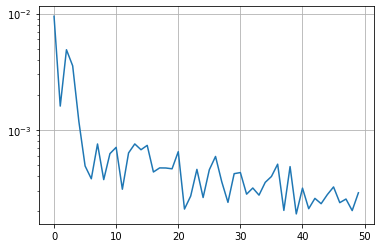

In [7]:
plt.plot(l)
plt.grid()
plt.yscale("log")

In [8]:
T = np.arange(0, 1.5 + 0.1, 0.1)
X = np.arange(0, 2 + 0.1, 0.1)
A, B = np.meshgrid(X, T)
grid = np.array([[t,x] for t in T for x in X])
Z = heat_model.model(grid).numpy().reshape((len(T),len(X)))

In [9]:
fig = go.Figure(data=[go.Surface(z=Z, x=X, y=T)])

fig.update_layout(title='Heat Equation', margin=dict(l=65, r=50, b=65, t=90))

fig.show()